In [1]:
import shap
import joblib
import numpy as np
import pandas as pd
import localmodules.conversor as c
from explainerdashboard import ClassifierExplainer, ExplainerDashboard


The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`

The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`


In [2]:
#Definição variáveis iniciais
file = './zDatabase/XAI - Limpo_dummified_minmax_smote.csv'
fileTrain = './zDatabase/XAI - Limpo_dummified_minmax_smote_train.csv'
fileTest = './zDatabase/XAI - Limpo_dummified_minmax_smote_test.csv'

name = 'XAI - Limpo_dummified_minmax_smote'
tc = 'surgycal margin'
data = pd.read_csv(file,index_col=tc,na_values='',sep=',', decimal='.')
df = pd.DataFrame(data)
rfb = joblib.load('./zDatabase/randomforests.joblib')

train: pd.DataFrame = pd.read_csv(fileTrain)
trnY: np.ndarray = train.pop(tc).values
trnX: np.ndarray = train.values
labels = pd.unique(trnY)
labels.sort()

test: pd.DataFrame = pd.read_csv(fileTest)
tstY: np.ndarray = test.pop(tc).values
tstX: np.ndarray = test.values

In [3]:
#Previsão
#[Age.at.MRI,Prostate.volume,PSA.value.at.MRI,Index.lesion.PIRADS.V2,Index.lesion.size,
# Capsular.contact.lenght_TLC,Smooth.capsular.bulging,Capsular.disruption,Unsharp.margin,
# Irregular.contour,Black.estrition.periprostatic.fat,Retoprostatic.angle.obliteration,
# Measurable.ECE,ECE.in.prostatectomy.specimen_gold.standard,Gleason.score,regra,surgycal margin] L=17
##-----------------------------------------------------------------------------------------------##
#[Age.at.MRI,Prostate.volume,PSA.value.at.MRI,Index.lesion.size,Capsular.contact.lenght_TLC,
# Smooth.capsular.bulging,Capsular.disruption,Unsharp.margin,Irregular.contour,Black.estrition.periprostatic.fat,
# Retoprostatic.angle.obliteration,Measurable.ECE,ECE.in.prostatectomy.specimen_gold.standard,Gleason.score
# regra,Index.lesion.PIRADS.V2_3,Index.lesion.PIRADS.V2_4,Index.lesion.PIRADS.V2_5,surgycal margin] L=19

#Conversão -> Transformação valor na posição [3] para 
col = ['Age.at.MRI','Prostate.volume','PSA.value.at.MRI','Index.lesion.size',
       'Capsular.contact.lenght_TLC','Smooth.capsular.bulging','Capsular.disruption','Unsharp.margin',
       'Irregular.contour','Black.estrition.periprostatic.fat','Retoprostatic.angle.obliteration',
       'Measurable.ECE','ECE.in.prostatectomy.specimen_gold.standard','Gleason.score','regra',
       'Index.lesion.PIRADS.V2_3','Index.lesion.PIRADS.V2_4','Index.lesion.PIRADS.V2_5','surgycal margin']
X = [0.444078947,0.2,0.352631579,0.37037037,0.05,0,0,0,0,0,0,0,0,0,1,0,0,1,0]
XX = c.dumm(X)
XXX = c.minmax(XX,data)
XXX.pop(-1)
Y = [XXX]

pred = rfb.predict(Y)
print("Input=%s, Predicted=%s" % (Y, pred))

Input=[[0.444078947, 0.2, 0.352631579, 0.05, 0.0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]], Predicted=[0]


(2, 162, 18)


X has feature names, but RandomForestClassifier was fitted without feature names


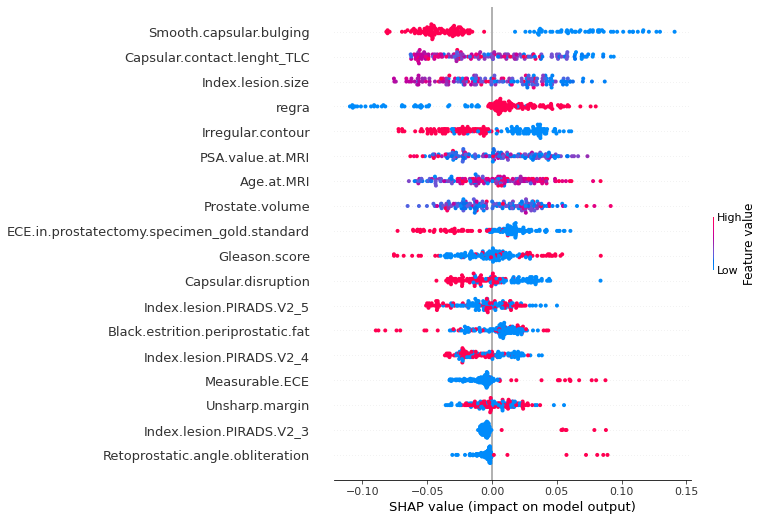

(2, 162, 18)


In [4]:
shap.initjs()
# use Kernel SHAP to explain test set predictions
explainer = shap.TreeExplainer(rfb)
shap_values = np.array(explainer.shap_values(df))
print(shap_values.shape)

shap_values_ = shap_values.transpose((1,0,2))

np.allclose(
    rfb.predict_proba(df),
    shap_values_.sum(2) + explainer.expected_value
)

shap.summary_plot(shap_values[0],df)
print(shap_values.shape)

In [8]:
explainer.expected_value

array([26.875])

In [4]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], df.iloc[0,:])

In [5]:
shap.force_plot(explainer.expected_value[1], shap_values[1][:1000,:], df.iloc[:1000,:])

In [23]:
col2 = ['Age.at.MRI','Prostate.volume','PSA.value.at.MRI','Index.lesion.size',
       'Capsular.contact.lenght_TLC','Smooth.capsular.bulging','Capsular.disruption','Unsharp.margin',
       'Irregular.contour','Black.estrition.periprostatic.fat','Retoprostatic.angle.obliteration',
       'Measurable.ECE','ECE.in.prostatectomy.specimen_gold.standard','Gleason.score','regra',
       'Index.lesion.PIRADS.V2_3','Index.lesion.PIRADS.V2_4','Index.lesion.PIRADS.V2_5']

x_patient = pd.DataFrame(data=[XXX],
                             columns=col2,
                             index=[0])
#explainer.shap_values(x_patient)[0].flatten()
#explainer.expected_value
data_patient = x_patient.to_json()
x_new = pd.read_json(data_patient)
x_new.values

array([[0.44407895, 0.2       , 0.35263158, 0.05      , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        ]])

In [30]:
#Dashboard Vizualizer
feature_descriptions = {
    "Age.at.MRI": "Age at MRI",
    "Prostate.volume": "Size of prostate",
    "PSA.value.at.MRI": "PSA value at MRI",
    "Index.lesion.size": "Size of the lesion",
    "Capsular.contact.lenght_TLC": "Length of capsular contact",
    "Smooth.capsular.bulging": "Smooth capsular bulging", 
    "Capsular.disruption": "Capsular disruption",
    "Unsharp.margin": "Unsharp margin",
    "Irregular.contour": "Irregular contour",
    "Black.estrition.periprostatic.fat" : "Black estrition periprostatic fat",
    "Retoprostatic.angle.obliteration":"Retoprostatic angle obliteration",
    "Measurable.ECE":"Measurable ECE",
    "ECE.in.prostatectomy.specimen_gold.standard":"ECE in prostatectomy specimen gold-standard",
    "Gleason.score":"Gleason score",
    "regra":"Rule followed by the surgeon",
    "Index.lesion.PIRADS.V2":"Index lesion PIRADSV2 - 3, 4 or 5",
}

explainer = ClassifierExplainer(rfb, test, tstY, 
  cats=[{'Index.lesion.PIRADS.V2': ['Index.lesion.PIRADS.V2_3', 'Index.lesion.PIRADS.V2_4', 'Index.lesion.PIRADS.V2_5']}],
  descriptions=feature_descriptions, # defaults to None
  labels=['Positive surgical margin', 'Negative surgical margin'], # defaults to ['0', '1', etc]
  #idxs = test_names, # defaults to X.index
  index_name = "Pacient", # defaults to X.index.name
  target = tc, # defaults to y.name
  )

db = ExplainerDashboard(explainer, 
  title="Prostatic Cancer Explainer", # defaults to "Model Explainer"
  whatif=False, # you can switch off tabs with bools
                        )
db.run(port=8050)

Detected RandomForestClassifier model: Changing class type to RandomForestClassifierExplainer...
Note: model_output=='probability', so assuming that raw shap output of RandomForestClassifier is in probability space...
Generating self.shap_explainer = shap.TreeExplainer(model)
Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
Generating layout...
Calculating shap values...
Calculating prediction probabilities...
Calculating metrics...


c:\Users\jonas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:434: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



Calculating confusion matrices...
Calculating classification_dfs...
Calculating roc auc curves...
Calculating pr auc curves...
Calculating liftcurve_dfs...


c:\Users\jonas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:434: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

c:\Users\jonas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:434: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

c:\Users\jonas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:434: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

c:\Users\jonas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:434: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

c:\Users\jonas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:434: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

c:\Users\jonas\AppData\Local\Programs\Python\Pytho

Calculating shap interaction values... (this may take a while)
Reminder: TreeShap computational complexity is O(TLD^2), where T is the number of trees, L is the maximum number of leaves in any tree and D the maximal depth of any tree. So reducing these will speed up the calculation.
Calculating dependencies...
Calculating permutation importances (if slow, try setting n_jobs parameter)...


c:\Users\jonas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:434: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

c:\Users\jonas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:434: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

c:\Users\jonas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:434: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

c:\Users\jonas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:434: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

c:\Users\jonas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:434: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

c:\Users\jonas\AppData\Local\Programs\Python\Pytho

Calculating pred_percentiles...
Calculating predictions...
Calculating ShadowDecTree for each individual decision tree...


c:\Users\jonas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:434: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

c:\Users\jonas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:434: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

c:\Users\jonas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:434: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

c:\Users\jonas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:434: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

c:\Users\jonas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:434: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Starting ExplainerDashboard on http://192.168.1.70:8050
Dash is running on http://0.0.0.0:8050/

Dash is running on http://0.0.0.0:8050/

Dash is running on http://0.0.0.0:8050/

Dash is running on http://0.0.0.0:8050/

 * Serving Flask app 'explainerdashboard.dashboards' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on all addresses.
 * Running on http://192.168.1.70:8050/ (Press CTRL+C to quit)
